In [1]:
import math
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict, Counter
from glob import glob

In [2]:
with open("data/TEXTEN1.txt", "r") as f:
    text_en = f.read()

with open("data/TEXTCZ1.txt", "r", encoding="iso8859_2") as f:
    text_cz = f.read()

In [134]:
def perturb(text, p):
    """
    Randomly replace letters with probability `p`,
    while keeping word barriers intact.
    """
    alphabet = list(set(text_en) - set(["\n"]))
    
    return "".join([c
                    if (random.random() > p or c == "\n")
                    else random.choice(alphabet)
                    for c in text])

In [122]:
X = np.arange(0, 1.01, step=0.2)
texts = [perturb(text_en, e).split("\n") for e in X]

def split_text(text):
    words = text.split("\n")
    bigrams = [("<START>", words[0])] + list(zip(words, words[1:])) + [(words[-1], "<END>")]
    
    return words, bigrams

In [123]:
import nltk.lm

In [124]:
def entropy(labels):
    freqdist = nltk.FreqDist(labels)
    probs = [freqdist.freq(l) for l in freqdist]
    return -sum(p * math.log(p,2) for p in probs)

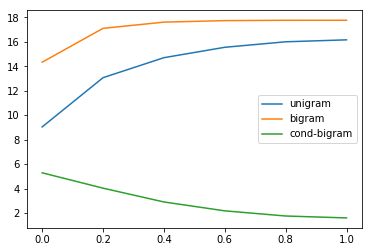

In [136]:
def perturb(text, p):
    alphabet = list(set(text_en) - set(["\n"]))
    
    return "".join([c
                    if (random.random() > p or c == "\n")
                    else random.choice(alphabet)
                    for c in text])

unigram = []
bigram = []
cond_bigram = []

for p in X:
    e1 = []
    e2 = []
    e3 = []
    
    for i in range(20):
        text = perturb(text_en, p).split("\n")
        
        e1.append(entropy(text))
        e2.append(entropy(nltk.bigrams(text)))
        e3.append(entropy(nltk.bigrams(text)) - entropy(text))
        
    unigram.append(np.mean(e1))
    bigram.append(np.mean(e2))
    cond_bigram.append(np.mean(e3))

plt.plot(X, unigram, label="unigram")
plt.plot(X, bigram, label="bigram")
plt.plot(X, cond_bigram, label="cond-bigram")
plt.legend()

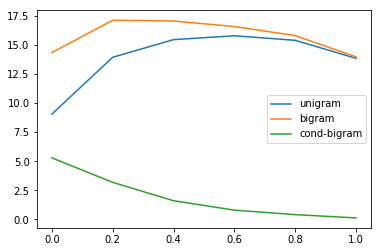

In [137]:
def perturb(text, p):
    alphabet = list(set(text_en)) # - set(["\n"]))
    
    return "".join([c
                    if (random.random() > p)# or c == "\n")
                    else random.choice(alphabet)
                    for c in text])

unigram = []
bigram = []
cond_bigram = []

for p in X:
    e1 = []
    e2 = []
    e3 = []
    
    for i in range(20):
        text = perturb(text_en, p).split("\n")
        
        e1.append(entropy(text))
        e2.append(entropy(nltk.bigrams(text)))
        e3.append(entropy(nltk.bigrams(text)) - entropy(text))
        
    unigram.append(np.mean(e1))
    bigram.append(np.mean(e2))
    cond_bigram.append(np.mean(e3))

plt.plot(X, unigram, label="unigram")
plt.plot(X, bigram, label="bigram")
plt.plot(X, cond_bigram, label="cond-bigram")
plt.legend()

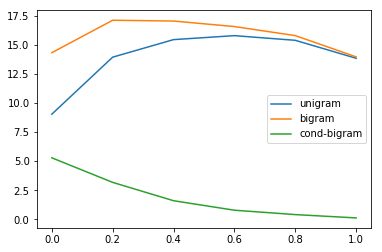

In [125]:
plt.plot(X, [entropy(text) for text in texts], label="unigram")
plt.plot(X, [entropy(nltk.bigrams(text)) for text in texts], label="bigram")
plt.plot(X, [entropy(nltk.bigrams(text)) - entropy(text) for text in texts], label="cond-bigram")
plt.legend()

In [ ]:
entropy(nltk.bigrams(words)) - entropy(words)

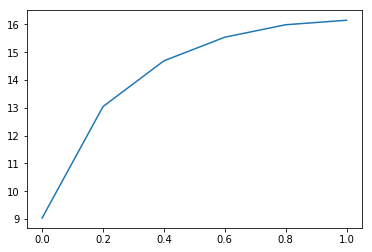

In [106]:
X = np.arange(0, 1.1, step=0.2)
ents = [entropy((perturb(text_en, e).split("\n"))) for e in X]
plt.plot(X, ents)
plt.show()

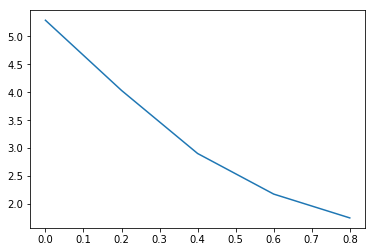

In [84]:
X = np.arange(0, 1, step=0.2)
ents = [my_ent((perturb(text_en, e).split("\n"))) for e in X]
plt.plot(X, ents)
plt.show()

In [83]:
def my_ent(words):
    tuples = [("<START>", words[0])] + list(zip(words, words[1:])) + [(words[-1], "<END>")]
    
    c_1 = Counter(words)
    c_2 = Counter(tuples)
    
    total_c1 = sum(c_1.values())
    total_c2 = sum(c_1.values())
    
    p_1 = {word: float(count) / total_c1 for word, count in c_1.items()}
    p_2 = {word: float(count) / total_c2 for word, count in c_2.items()}

    p_2c = dict()
    
    for key in c_2.keys():
        i, j = key

        if c_1[i] == 0:
            p_2c[key] = 0
        else:
            p_2c[key] = float(p_2[key]) / p_1[i]

            
    cond_entropy = 0

    for key in c_2.keys():
        if key in p_2c and p_2c[key] > 0:
            cond_entropy -= p_2[key] * math.log2(p_2c[key])

    # cond_entropy = -sum([p_1[key] * math.log2(p_1[key]) for key in p_1.keys()])            

    return cond_entropy

In [73]:
my_ent(words)

(14.324922969881143, 20522.558367901383)

In [53]:
nltk.lm.NgramCounter(words)

TypeError: Ngram <W> isn't a tuple, but <class 'str'>

In [35]:
text_en[:40].replace("\n", " "), perturb(text_en[:40], 1).replace("\n", " ")

('WHEN on board H . M . S . Beagle as natu',
 '57BvsWRTRiM!g0Jr2,BOAOjUYB1;MSx.Fr;M1l8M')

In [88]:
def ngram_list(text,n):  
    ngram=[]  
    count=0  
    for token in text[:len(text)-n+1]:  
        ngram.append(text[count:count+n])  
        count=count+1  
    return ngram

def condentropy(data):
    def ngram_counts(text, n):
        ngram_d = {}
        ngram_l = ngram_list(text, n)
        
        for item in ngram_l:
            ngram_d[' '.join(item)] = (ngram_d[' '.join(item)] + 1) if ' '.join(item) in ngram_d else 1 
        return ngram_d
    
    uni_gram = ngram_counts(data, 1)
    bi_gram = ngram_counts(data, 2)
    N = sum(uni_gram.values())
    H = 0    
    
    for key in bi_gram.keys():
        H -= bi_gram[key] / (1.0 * N) * math.log(bi_gram[key] / (1.0 * uni_gram[key.split(' ')[1]]),2)
    
    return H

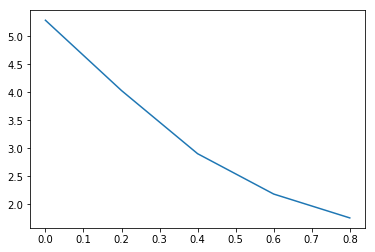

In [89]:
X = np.arange(0, 1, step=0.2)
ents = [condentropy(perturb(text_en, e).split("\n")) for e in X]
plt.plot(X, ents)
plt.show()

In [71]:
def text_entropy(text, plot=False):
    words = text # .split("\n")
    
    tuples = [("<START>", words[0])] + list(zip(words, words[1:])) + [(words[-1], "<END>")]
    
    c_1 = Counter(words)
    c_2 = Counter(tuples)
    
    total_c1 = sum(c_1.values())
    total_c2 = sum(c_1.values())
    
    p_1 = {word: float(count) / total_c1 for word, count in c_1.items()}
    p_2 = {word: float(count) / total_c2 for word, count in c_2.items()}
    
    if plot:
        print(sorted(c_1.values())[-100:])
        plt.plot(np.log(list(sorted(c_1.values()))))
        plt.show()
        plt.plot(np.log(list(sorted(set(c_1.values())))))
        plt.show()

    p_2c = dict()
    
    for key in c_2.keys():
        i, j = key

        if c_1[i] == 0:
            p_2c[key] = 0
        else:
            p_2c[key] = float(p_2[key]) / p_1[i]

            
    cond_entropy = 0

    for key in c_2.keys():
        if key in p_2c and p_2c[key] > 0:
            cond_entropy -= p_2[key] * math.log2(p_2c[key])

#     cond_entropy = -sum([p_1[key] * math.log2(p_1[key]) for key in p_1.keys()])
            
    perplexity = 2 ** cond_entropy

    return cond_entropy, perplexity

In [33]:
text_entropy(text_en), condentropy(text_en)

((5.287460725971182, 39.055686806417654),
 (3.3284266994729443, 10.045146499088256))

In [31]:
text_entropy(perturb(text_en, 1))

(1.602244014245126, 3.036151990547778)

In [18]:
def entplot(f):
    X = np.arange(0, 1, step=0.2)
    ents = [f(perturb(text_en, e)) for e in X]
    plt.plot(X, [a for a, b in ents])
    plt.show()

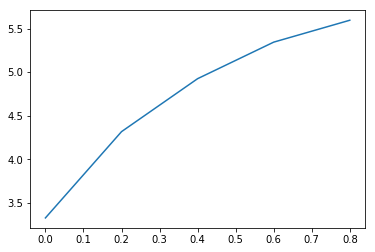

In [21]:
entplot(text_entropy)

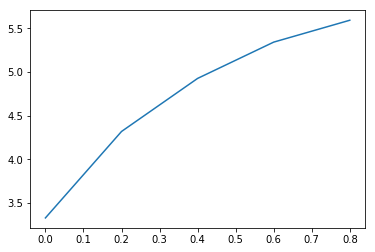

In [39]:
entplot(condentropy)

In [27]:
text_entropy("he he he he".replace(" ", "\n"))

(-0.0, 1.0)

In [28]:
text_entropy("a b c d".replace(" ", "\n"))

(2.0, 4.0)

In [15]:
s = perturb(text_en, 1)

In [16]:
c = Counter(perturb(text_en, 1).split("\n"))

In [17]:
sorted(c.items(), key=lambda x: x[1], reverse=True)[:100]

[('!', 447),
 ('G', 426),
 ('L', 420),
 ('s', 416),
 ('J', 413),
 ('C', 406),
 ('q', 405),
 ("'", 404),
 ('&', 401),
 ('H', 400),
 (';', 399),
 ('F', 397),
 ('c', 396),
 ('N', 393),
 ('v', 391),
 ('V', 391),
 ('n', 391),
 ('1', 391),
 ('?', 391),
 ('T', 389),
 ('g', 389),
 (')', 389),
 ('O', 389),
 ('u', 388),
 ('E', 388),
 ('2', 387),
 ('9', 386),
 ('7', 385),
 ('x', 384),
 ('X', 384),
 ('B', 384),
 ('I', 384),
 ('o', 383),
 ('.', 383),
 ('p', 383),
 ('8', 383),
 ('/', 382),
 ('m', 382),
 ('h', 382),
 ('P', 380),
 ('j', 380),
 (',', 380),
 ('U', 379),
 ('f', 379),
 ('d', 378),
 ('5', 378),
 ('l', 377),
 ('Q', 375),
 ('Y', 374),
 ('a', 373),
 ('W', 372),
 ('D', 372),
 (':', 371),
 ('k', 369),
 ('i', 368),
 ('y', 368),
 ('Z', 366),
 ('M', 365),
 ('K', 365),
 ('3', 364),
 ('A', 364),
 ('r', 363),
 ('4', 363),
 ('6', 363),
 ('e', 360),
 ('w', 360),
 ('(', 358),
 ('b', 356),
 ('"', 355),
 ('0', 354),
 ('z', 353),
 ('t', 352),
 ('R', 349),
 ('S', 330),
 ('du', 21),
 ('eI', 21),
 ('7P', 18),